In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr

import json

rng = np.random.default_rng(42)

## Un premier regard: La quantité probable de particules dans un polygone

_doc version: 1, doc type: submission, doc title: A fist look, author: Roger Erismann, roger@hammerdirt.ch_

Ce document est destiné à tester la mise en œuvre de méthodes statistiques sur des données de comptage. Les données sont nettoyées dans une étape préalable. Le problème se résout autour des quantités relatives de 18 types de particules différentes (3 catégories de matériaux et 6 catégories de couleurs par matériau). Il y a des échantillons provenant de 25 plages différentes du Lac Léman.

Après discussion avec les chercheurs, les 18 particules différentes ont été combinées en deux catégories. Les matériaux ont été combinés car, au départ, les objets qui n'étaient pas des fibres étaient classés en fragments durs ou souples. Ainsi, les fragments comprennent à la fois des particules inorganiques souples et des particules inorganiques fragiles, qui ne sont pas des fibres. 

1. fibres
2. fragments (durs et souples)

Les résultats pour tous les matériaux et la zone de plage sont examinés dans la section deux.

**Table des matières**

1. [Moyen par événement par plage](section-one-01)
2. [particules trouvées par matériau et par emplacement sur la plage.](section-two-01)
3. [Comparaison de ligne d'eau et arrière de la plage](section-three-01)
4. [La fonction de répartition (observé)](section-four-01)
5. [Modèle linéaire généralisé (MLG/GLM)](section-five-01)
   1. Les résultats par région et par matériau
   2. Intuition (ou pourquoi pas la régression linéaire)
   3. Le rapport entre les fragments et les fibres et le total.
   4. Un modèle discret
   5. [Vérifications de la distribution marginale postérieure](section-five-01-a)
      1. posterior predictive checks
      2. probability integral transform
      3. leave one out cross validation
      4. Observés et prévus, total par événement
6. [Pièces par mètre carré](section-six)

In [2]:
# first set of data
c = pd.read_csv("data/copy_of_asl.csv")
c= c.fillna(0)

# column groups by material type
fibres = ['fr', 'fb', 'fj', 'fw', 'fn', 'fa']
fdure = ['fdr', 'fdb', 'fdj', 'fdw', 'fdn', 'fda']
souple = ['fsr', 'fsb', 'fsj', 'fsw', 'fsn', 'fsa']
fragments = [*fdure, *souple]

name_the_zones = {1:"ligne-d'eau", 2:"plage-seche"}

# the sum of all particles for one sample
c["added"] = c[[*fragments, *fibres]].sum(axis=1)
# the sum of the different groups
c["fibres"] = c[fibres].sum(axis=1)
c["fdure"] = c[fdure].sum(axis=1)
c["souple"] = c[souple].sum(axis=1)
c["fragments"] = c[fragments].sum(axis=1)
# the emplacement on the beach
c["z"] =c["z"].map(lambda x: name_the_zones[x])

# the samples where at least one particle was recorded
cInventoryComplete = c[c.added > 0].copy()
cAdded = cInventoryComplete[["p", "E", "z", "m", "fibres", "fdure", "souple", "fragments"]].copy()

# work columns
id_vars = ["p", "E", "z", "m"]
value_vars = ["fibres", "fdure", "souple"]
columns={"p":"place", "E":"événement", "z":"zone", "m":"substrat", "value":"y", "variable":"matériel"}

# make workdata to long form
workData = pd.melt(cAdded, id_vars=id_vars, value_vars=value_vars)
workData.rename(columns=columns, inplace=True)
cInventoryComplete.to_csv("data/workDataOne.csv", index=False)

# colors and styles
zone_palette = {"plage-seche":"darkgoldenrod","ligne-d'eau":"lightseagreen"}
region_palette = {"GE":"darkgoldenrod","VD":"lightseagreen"}
sns.set_style("whitegrid")

(section-one-01)=
### Comptage moyen par événement par plage

#### Toutes variantes confondues. 

Le nombre moyen pour chaque événement variait de 19 à 180 fragments par échantillon de 5 X 10 X 10 cm. Les événements pour lesquels aucun compte n'a été rapporté ont été retirés de ce test.

**Note** Ces chiffres sont-ils complets ? Certains semblent très bas ou toutes les particules n'ont pas encore été comptées ?

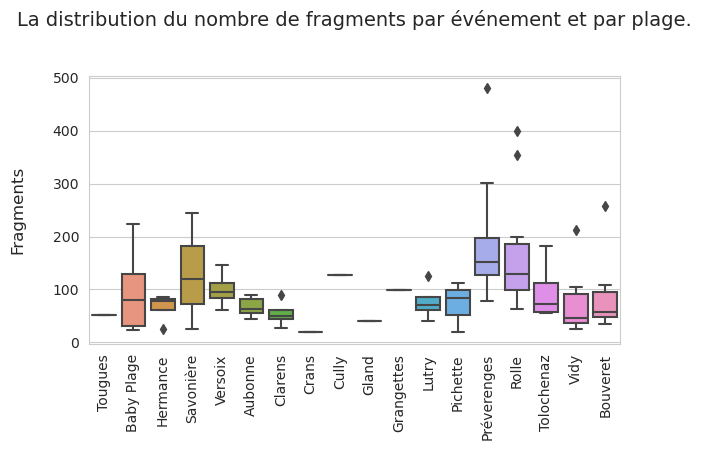

In [3]:
a_df= workData.groupby(["événement", "place"], as_index=False)["y"].sum()

fig, ax = plt.subplots()

sns.boxplot(data=a_df, x="place", y="y", hue="place", width=.8, ax=ax, dodge=False)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=6).remove()
ax.set_title("La distribution du nombre de fragments par événement et par plage.\n", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()

plt.show()

In [4]:
f = f"""
Le nombre moyen de particules par événement tous les sites et matériaux

NOTE: mean = moyen, count=nombre d'événements, std=écart type

{a_df.y.describe()} 

"""
print(f)


Le nombre moyen de particules par événement tous les sites et matériaux

NOTE: mean = moyen, count=nombre d'événements, std=écart type

count     96.000000
mean     114.822917
std       82.129038
min       19.000000
25%       57.750000
50%       95.000000
75%      143.000000
max      481.000000
Name: y, dtype: float64 




In [5]:
f = f""" 
Le nombre moyen de particules par événement et par plage

{a_df.groupby("place").y.mean()}

"""
print(f)


 
Le nombre moyen de particules par événement et par plage

place
Aubonne         66.833333
Baby Plage      90.875000
Bouveret        90.857143
Clarens         54.250000
Crans           19.000000
Cully          128.000000
Gland           40.000000
Grangettes      99.000000
Hermance        66.500000
Lutry           77.000000
Pichette        72.000000
Préverenges    179.117647
Rolle          153.761905
Savonière      130.000000
Tolochenaz      95.750000
Tougues         51.000000
Versoix         99.750000
Vidy            78.166667
Name: y, dtype: float64




(section-two-01)=
### Comparaison du nombre de particules trouvées par matériau et par emplacement sur la plage.

Même s'il semble qu'il y ait plus de particules sur la plage-sèche, cela peut être dû à quelques événements seulement. Le matériau souple a été identifié le moins souvent, et cela semble se généraliser à tous les événements.

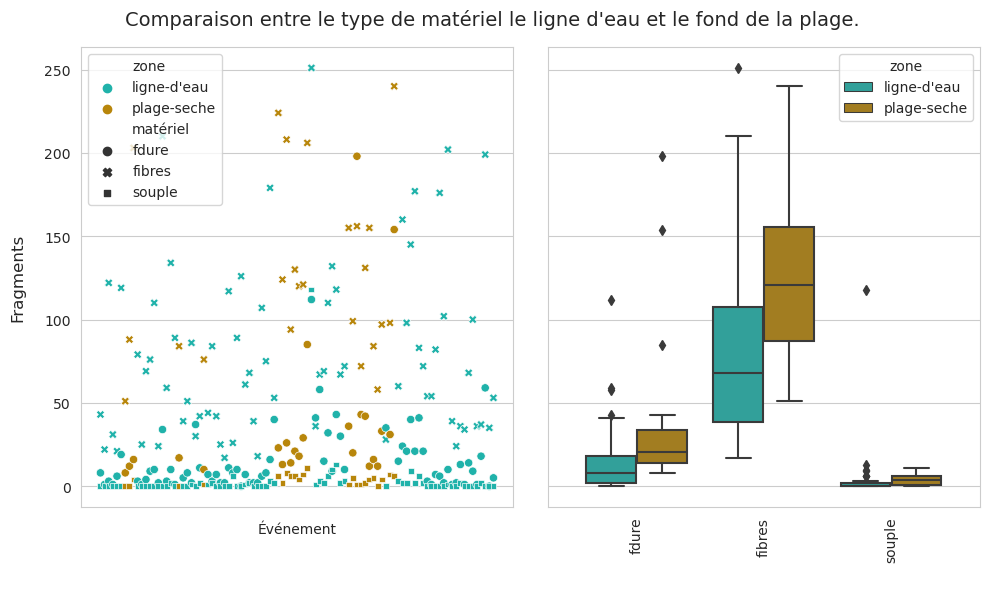

In [6]:
a_df= workData.groupby(["événement","zone", "matériel"], as_index=False)["y"].sum()

fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

ax = sns.scatterplot(data=a_df, x="événement", y="y", hue="zone", palette=zone_palette, ax=axs[0], style="matériel")
ax.xaxis.set_ticklabels([])
ax.grid(axis='x')
ax.set_xlabel("Événement")
ax.set_ylabel("Fragments", fontsize=12, labelpad=14)
ax.legend(loc="upper left")

axOne = axs[1]
sns.boxplot(data=a_df, x="matériel", y="y", hue="zone", palette=zone_palette, width=.8, ax=axOne, dodge=True)
axOne.tick_params(axis="x", which="both", labelrotation=90)
axOne.set_ylabel(" ")
axOne.set_xlabel(" ")
axOne.margins(x=.9, y=None)

plt.suptitle("Comparaison entre le type de matériel le ligne d'eau et le fond de la plage. ", fontsize=14, y=.98)
plt.tight_layout()


plt.show()

In [7]:
f = f""" 
Le nombre moyen de particules par zone et matériel

{a_df.groupby(["zone", "matériel"], as_index=False).y.mean()}

"""
print(f)

 
Le nombre moyen de particules par zone et matériel

          zone matériel           y
0  ligne-d'eau    fdure   14.319444
1  ligne-d'eau   fibres   79.541667
2  ligne-d'eau   souple    2.930556
3  plage-seche    fdure   37.041667
4  plage-seche   fibres  128.083333
5  plage-seche   souple    3.791667




(section-three-01)=
### Ligne d'eau et arrière de la plage

On peut voir ici que les valeurs de la plage-sèche ne proviennent que de quelques endroits. Nous allons attendre jusqu'à ce que les comptages arrivent pour ces endroits.

Cependant, les méthodes d'analyse peuvent toujours être testées sur les données de la ligne d'eau. Nous allons également combiner le matériel fragmenté en un seul groupe "fragments".

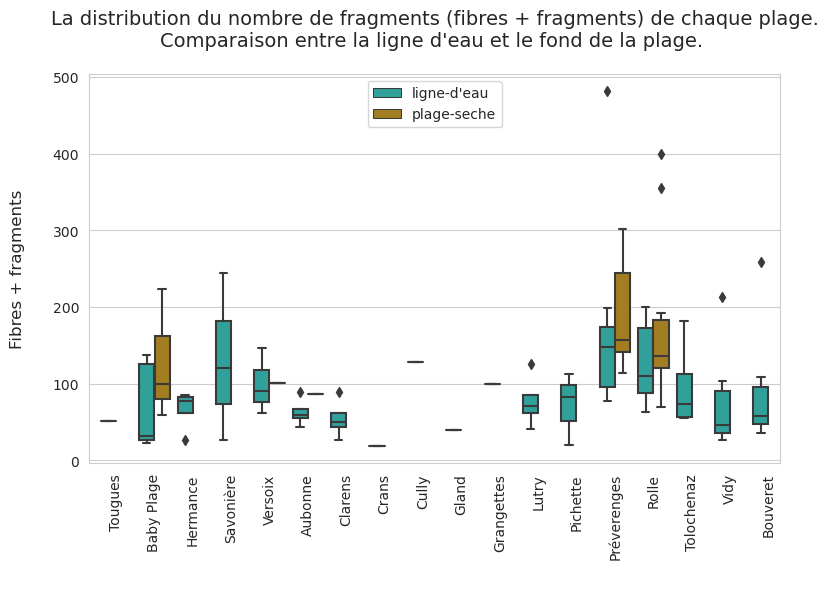

In [8]:
a_df = workData.groupby(["événement","place","zone"], as_index=False)["y"].sum()

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=a_df, x="place", y="y", hue="zone", palette=zone_palette, width=0.8, ax=ax, dodge=True)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fibres + fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center")
ax.set_title("La distribution du nombre de fragments (fibres + fragments) de chaque plage.\nComparaison entre la ligne d'eau et le fond de la plage. ", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()
plt.show()

### Ligne d'eau comparée à la plage-sèche tous types de matériaux et plages confondus.

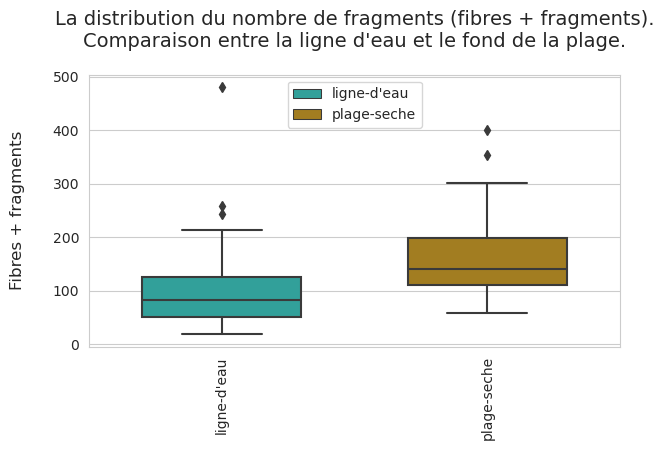

In [9]:
fig, ax = plt.subplots()

sns.boxplot(data=a_df[["zone", "y"]], x="zone", y="y", hue="zone", palette=zone_palette, width=.6, ax=ax, dodge=False)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fibres + fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center")
ax.set_title("La distribution du nombre de fragments (fibres + fragments).\nComparaison entre la ligne d'eau et le fond de la plage.", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()
plt.show()

(section-four-01)=
### La fonction de répartition

Même s'il y a un nombre différent d'échantillons et quelques valeurs extrêmes. Les deux zones de plage ont des distributions cumulatives très similaires.

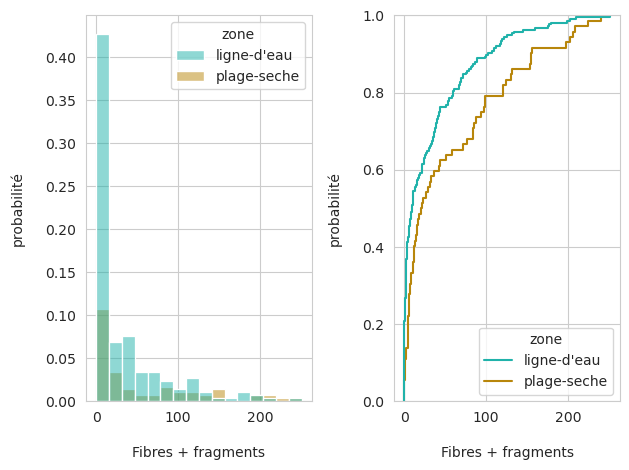

In [10]:
fig, axs = plt.subplots(1,2, sharey=False)

sns.ecdfplot(data=workData, x="y",  ax=axs[1], hue="zone", palette=zone_palette)
sns.histplot(data=workData, x="y",  ax=axs[0], hue="zone", stat="probability", palette=zone_palette)
axs[0].set_ylabel("probabilité", labelpad=15)
axs[1].set_ylabel("probabilité", labelpad=15)
axs[0].set_xlabel("Fibres + fragments", labelpad=15)
axs[1].set_xlabel("Fibres + fragments", labelpad=15)
plt.tight_layout()
plt.show()

(section-five-01)=
### Modèle linéaire généralisé (MLG/GLM)

Il y a plus d'échantillons de la ligne d'eau que de la plage sèche. Notez également qu'indépendamment de l'emplacement sur la plage, les fragments souples ne représentent qu'une faible proportion de tous les fragments. Pour ces raisons, dans les modèles suivants, nous ne considérons que les échantillons de la ligne d'eau. Les deux catégories de fragments (souples, durs) sont combinées en un seul groupe appelé fragments.

Note : Parmi les échantillons dont le total est supérieur à zéro, 49 proviennent du canton de Vaud (VD), 15 du canton de Genève (GE). Il y a un échantillon de Haute Savoie (74) et sept du Valais (VS). Par conséquent, nous ne considérons que les régions qui ont le plus grand nombre d'échantillons : VD, GE.

#### Résultats par région et matériel

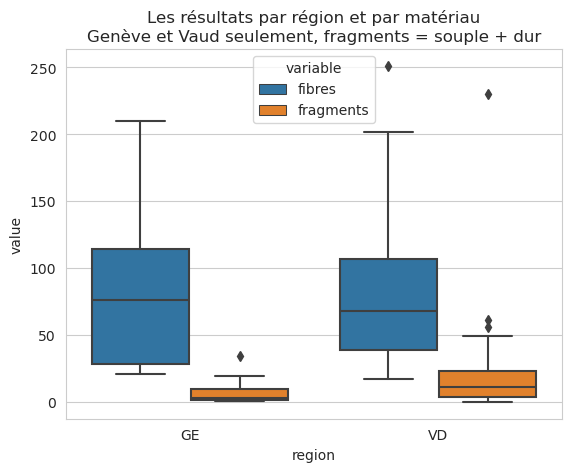

In [11]:
# combine the fibres and fragments
cAdded["total"] = cAdded[["fibres", "fragments"]].sum(axis=1)
mask = (cAdded.z == "ligne-d'eau") & (cAdded.total > 0)
cData  = cAdded[mask][["p", "E", "m","fibres", "fragments", "total"]].copy()

# make city and region abbreviations from place and event columns
cData["city"] = cData.p.map(lambda x: x[0:3].strip())
cData["region"] = cData.E.map(lambda x: x[0:2].strip())

# limit data to the regions with the most samples
cDataT = cData[cData.region.isin(["GE", "VD"])].copy()
cDataT.reset_index(drop=True, inplace=True)
cDataT = cDataT[["city", "region", "E", "fibres", "fragments", "total"]].copy()

# put data to long form
cMelted = pd.melt(cDataT, id_vars=["city", "E", "region"], value_vars=["fibres", "fragments",])
cMelted.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots()

sns.boxplot(data=cMelted, x="region", y="value", hue="variable", ax=ax)
ax.set_title("Les résultats par région et par matériau\nGenève et Vaud seulement, fragments = souple + dur")

plt.show()

### Intuition (ou pourquoi pas la régression linéaire)

La régression linéaire ordinaire prédit la valeur attendue d'une quantité inconnue donnée (la variable de réponse, une variable aléatoire) comme une combinaison linéaire d'un ensemble de valeurs observées (prédicteurs). Cela implique qu'une variation constante d'un prédicteur entraîne une variation constante de la variable de réponse (c'est-à-dire un modèle de réponse linéaire). Cette hypothèse est appropriée lorsque la variable de réponse peut varier, en bonne approximation, indéfiniment dans un sens ou dans l'autre, ou plus généralement pour toute quantité qui ne varie que d'une quantité relativement faible par rapport à la variation des variables prédictives, par exemple les hauteurs humaines.

Cependant, ces hypothèses sont inappropriées pour certains types de variables de réponse. Par exemple, dans les cas où l'on s'attend à ce que la variable de réponse soit toujours positive (notre cas) et varie sur une large plage, des changements d'entrée constants conduisent à des changements de sortie à variation géométrique (c'est-à-dire exponentielle), plutôt qu'à variation constante. À titre d'exemple, supposons qu'un modèle de prédiction linéaire apprenne, à partir de certaines données (peut-être principalement tirées de grandes plages), qu'une baisse de température de 10 degrés entraînerait une diminution de 1 000 personnes de la fréquentation de la plage. Il est peu probable que ce modèle se généralise bien sur des plages de tailles différentes. Plus précisément, le problème est que si vous utilisez le modèle pour prédire la nouvelle fréquentation avec une baisse de température de 10 pour une plage qui reçoit régulièrement 50 plagistes, vous prédire une valeur de fréquentation impossible de -950. Logiquement, un modèle plus réaliste prévoirait plutôt un taux constant d'augmentation de la fréquentation des plages (par exemple, une augmentation de 10 degrés entraîne un doublement de la fréquentation des plages, et une baisse de 10 degrés entraîne une diminution de moitié de la fréquentation). Un tel modèle est appelé modèle à réponse exponentielle (ou modèle log-linéaire, puisque le logarithme de la réponse est censé varier linéairement).  [wikepedia](https://fr.wikipedia.org/wiki/Mod%C3%A8le_lin%C3%A9aire_g%C3%A9n%C3%A9ralis%C3%A9)

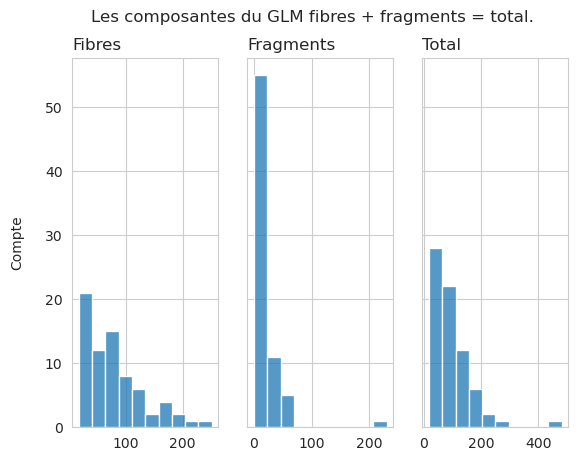

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True)

sns.histplot(cData.fibres.values, bins=10, ax=axs[0])
sns.histplot(cData.fragments.values,  bins=10, ax=axs[1])
sns.histplot(cData.total.values,  bins=10, ax=axs[2])

axs[0].set_title("Fibres", fontsize=12, loc="left")
axs[1].set_title("Fragments", fontsize=12, loc="left")
axs[2].set_title("Total", fontsize=12, loc="left")

axs[0].set_ylabel("Compte", labelpad=15)

plt.suptitle("Les composantes du GLM fibres + fragments = total.")
plt.show()

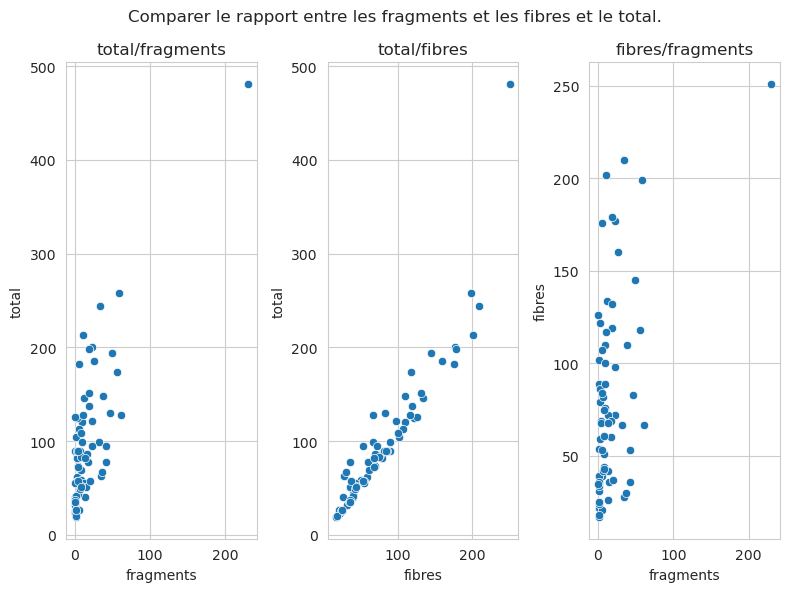

In [13]:
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(8,6))

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

sns.scatterplot(data=cData, x="fibres", y="total", ax=ax2)
sns.scatterplot(data=cData, x="fragments", y="total", ax=ax1)
sns.scatterplot(data=cData, x="fragments", y="fibres", ax=ax3)

ax1.set_title("total/fragments")
ax2.set_title("total/fibres")
ax3.set_title("fibres/fragments")

plt.suptitle("Comparer le rapport entre les fragments et les fibres et le total.")
plt.tight_layout()

plt.show()

### Modèle continu ou discret ?

Un échantillon est le contenu d'un polygone de 500 cm³. Ce qui signifie qu'il peut être considéré sous la forme compte/500, ou le taux de fragments par 500cm³. **Nous allons considérerons le cas, discret**. En d'autres termes, les échantillons sont considérés comme une série d'expériences indépendantes et et identiquement distribuée [(IID)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables).


```python


# référence pour indexer les valeurs des résultats observés aux prédictions du modèle. 
coords = {"component":comp_labels, "region": rlabels, "obs_id":cMelted.index.values}

with pm.Model(coords=coords) as glmNegativeBinomialRegion:
    
    # cela indexe les résultats observés aux valeurs calculées    
    region_idx = pm.Data("regions", regions, dims="obs_id", mutable=True)
    comp_idx = pm.Data("components", components, dims="obs_id", mutable=True)
    observed = pm.ConstantData("obs", cMelted.value.values, dims="obs_id")
    
    # la proposition de répartition des résultats par région
    region = pm.Normal("r", mu=0, sigma=1, dims="region")
    # la proposition de répartition des résultats par matériel
    comp = pm.Normal("c", mu=0, sigma=1, dims="component")
    
    # les paramètre d'intérêt      
    mu = pm.Deterministic("mu", comp[comp_idx] + comp[comp_idx]*region[region_idx], dims="obs_id")
    alpha = pm.Exponential("alpha", 0.5)    
    
    # le résultat de ce calcul est la distribution postérieure
    found = pm.NegativeBinomial("found", mu=pm.math.exp(mu), alpha=alpha, observed=observed)
```


### Un modèle discret

In [14]:
components, comp_labels = pd.factorize(cMelted.variable)
regions, rlabels = pd.factorize(cMelted.region)

coords = {"component":comp_labels, "region": rlabels, "obs_id":cMelted.index.values}

with pm.Model(coords=coords) as glmNegativeBinomialRegion:
    
    region_idx = pm.Data("regions", regions, dims="obs_id", mutable=True)
    comp_idx = pm.Data("components", components, dims="obs_id", mutable=True)
    observed = pm.ConstantData("obs", cMelted.value.values, dims="obs_id")
    
    region = pm.Normal("r", mu=0, sigma=1, dims="region")    
    comp = pm.Normal("c", mu=0, sigma=1, dims="component")
        
    mu = pm.Deterministic("mu", comp[comp_idx] + comp[comp_idx]*region[region_idx], dims="obs_id")
    alpha = pm.Exponential("alpha", 0.5)    
    
    found = pm.NegativeBinomial("found", mu=pm.math.exp(mu), alpha=alpha, observed=observed)

with glmNegativeBinomialRegion:
    stwo = pm.sample(1000, tune=2000)
    pst = pm.sample_posterior_predictive(stwo)
    stwo.extend(pst)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, c, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 52 seconds.
The acceptance probability does not match the target. It is 0.8818, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
np.exp(az.summary(stwo, kind="stats", var_names=["r", "c"]))

,mean,sd,hdi_3%,hdi_97%
r[GE],1.186491,5.344137,0.044735,6.315456
r[VD],1.319166,6.252616,0.040075,8.749530
c[fibres],2.382142,7.530790,0.045502,16.135148
c[fragments],1.755932,3.709882,0.134930,6.147220


(section-five-01-a)=
### Marginal posterior predictive checks: Leave One Out (LOO) Probability Integral Transform (PIT)

Traduit d'ici: https://oriolabrilpla.cat/python/arviz/pymc3/2019/07/31/loo-pit-tutorial.html

L'un des piliers de la statistique bayésienne consiste à travailler avec la distribution postérieure des paramètres au lieu d'utiliser des estimations ponctuelles et des erreurs ou des intervalles de confiance. Nous savons tous comment obtenir cette distribution postérieure compte tenu de la vraisemblance (likelihood) , de l'information apriori (prior information) : 
**p(y<sup>∗</sup>∣y)=∫p(y<sup>∗</sup>∣θ)p(θ∣y)dθ**.

Où y∗ est la donnée non observée possible et y est la donnée observée. Par conséquent, si notre modèle est correct, les données observées et le prédictif postérieur suivent la même fonction de densité de probabilité (pdf) ou fonction de mass de probabilité (pmf). Afin de vérifier si cela est vrai, il est courant d'effectuer des contrôles de prédiction postérieure en comparant la prédiction postérieure aux données observées.

Une autre alternative consiste à effectuer des vérifications LOO-PIT, qui sont une sorte de vérifications prédictives postérieures marginales. Marginaux parce que nous comparons chaque observation uniquement avec les échantillons prédictifs postérieurs correspondants au lieu de combiner toutes les observations et tous les échantillons prédictifs postérieurs. Comme son nom l'indique, cette méthode combine deux concepts différents, la validation croisée Leave-One-Out et la transformation intégrale des probabilités.

#### Probability Integral Transform 

La démonstration mathématique peut être trouvée sur [wikipedia](https://en.wikipedia.org/wiki/Probability_integral_transform). Cependant, ici, au lieu de la reproduire, je vais essayer d'exposer l'intuition derrière ce fait. On peut l'imaginer avec les échantillons postérieurs d'une exécution MCMC. Si nous disposons d'un nombre suffisant d'échantillons, la probabilité qu'un nouvel échantillon se situe entre les deux plus petites valeurs sera la même que la probabilité qu'un nouvel échantillon se situe entre les deux valeurs les plus proches de la médiane.

Ceci est dû au fait que la probabilité autour des plus petites valeurs sera plus faible, mais elles seront plus éloignées, alors que la probabilité autour de la médiane sera plus grande mais elles seront extrêmement proches. Ces deux effets se compensent et la probabilité est bien la même. Ainsi, la probabilité est constante indépendamment du carré dans lequel le nouvel échantillon tomberait, ce qui n'est compatible qu'avec une distribution uniforme.

#### Leave-One-Out Cross Validation:

La validation croisée est une façon d'essayer de résoudre le problème de toutes les données futures que j'ai mentionnées jusqu'à présent. Nous ne disposons pas de ces données futures, alors comment sommes-nous censés faire des calculs avec elles ? La validation croisée résout ce problème en divisant les données observées en KK sous-ensembles, en excluant un sous-ensemble des données utilisées pour ajuster le modèle (il s'agit donc de données inconnues du modèle, c'est-à-dire de données futures), puis en utilisant ce sous-ensemble exclu comme données futures. En général, pour obtenir de meilleurs résultats, ce processus est effectué K fois, en excluant un sous-ensemble différent à chaque fois.

LOO-CV est un cas particulier où le nombre de sous-ensembles est égal au nombre d'observations, de sorte qu'à chaque itération, une seule observation est exclue. En d'autres termes, nous ajustons le modèle une fois par observation en excluant uniquement cette observation.

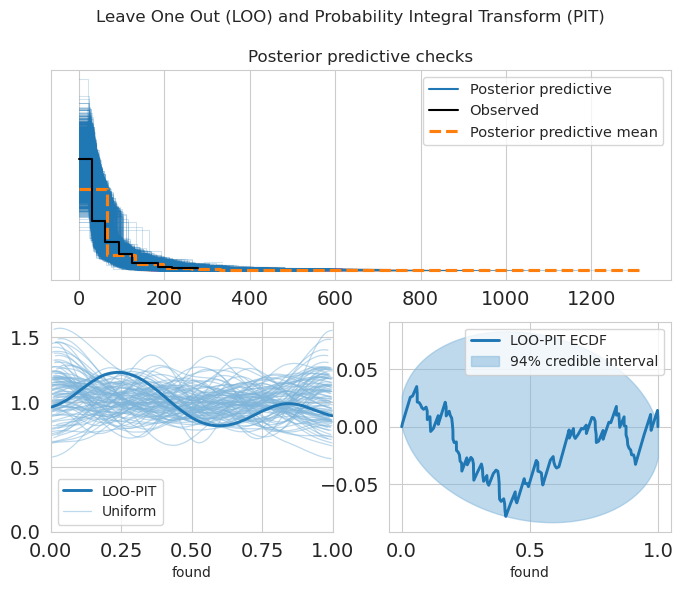

In [16]:
# excellent article from a developer at PyMC
# https://oriolabrilpla.cat/python/arviz/pymc/xarray/2022/06/07/pymc-arviz.html

def plot_ppc_loopit(idata, fig, title):    
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); 
    ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="found", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

fig = plt.figure(figsize=(8,6))

plot_ppc_loopit(stwo, fig, "Posterior predictive checks")

plt.suptitle("Leave One Out (LOO) and Probability Integral Transform (PIT)", y=.98)

plt.show()

**Interpretation**: Les valeurs observées sont similaires aux valeurs prédictives postérieures superposées (graphique du haut). Il en va de même pour les valeurs de LOO-PIT (en bas à gauche). Cependant, la différence entre la fonction de répartion empirique (ECDF) et la CDF uniforme idéale peut présenter un léger biais étant donné que la ligne pousse vers l'extrémité inférieure de l'enveloppe crédible de 94 %.

In [17]:
# split the observed data into regions
ge = cMelted[cMelted.region == "GE"]
vd = cMelted[cMelted.region == "VD"]

# get the index number for each record type
# geneva index fibers and fragments
geFindex = ge[ge.variable == "fragments"].index
geFbrsIndex = ge[ge.variable == "fibres"].index
# vaud index fibers and fragments
vdFindex = vd[vd.variable == "fragments"].index 
vdFbrsIndex = vd[vd.variable == "fibres"].index

# retrieve the posterior predictive samples with the same index
# geneva
ai = stwo.posterior_predictive.sel({'found_dim_0':geFindex}).found.values
bi = stwo.posterior_predictive.sel({'found_dim_0':geFbrsIndex}).found.values
# vaud
ci = stwo.posterior_predictive.sel({'found_dim_0':vdFindex}).found.values
di = stwo.posterior_predictive.sel({'found_dim_0':vdFbrsIndex}).found.values

# combine the fibres and fragments
pp_found = ai + bi # geneva
pp_found_ravel = np.ravel(pp_found)

pp_foundvd = ci + di # vaud
pp_found_ravelvd = np.ravel(pp_foundvd)

# save the posterior predictive samples for this example to .JSON
def saveToJson(file_name, data):
    with open(file_name, "w") as afile:
        json.dump(data, afile)
        
geneva_posterior = [
    ["data/fibersGePosteriorPredictive.json", np.ravel(bi).tolist()],
    ["data/fragmentsGePosteriorPredictive.json", np.ravel(ai).tolist()],
    ["data/totalGePosteriorPredictive.json", pp_found_ravel.tolist()]
]

for apair in geneva_posterior:
    saveToJson(apair[0], apair[1])

vaud_posterior = [
    ["data/fragmentsVdPosteriorPredictive.json", np.ravel(ci).tolist()],
    ["data/fibersVdPosteriorPredictive.json",np.ravel(di).tolist()],
    ["data/totalVdPosteriorPredictive.json", pp_found_ravelvd.tolist()]
]

for apair in vaud_posterior:
    saveToJson(apair[0], apair[1])

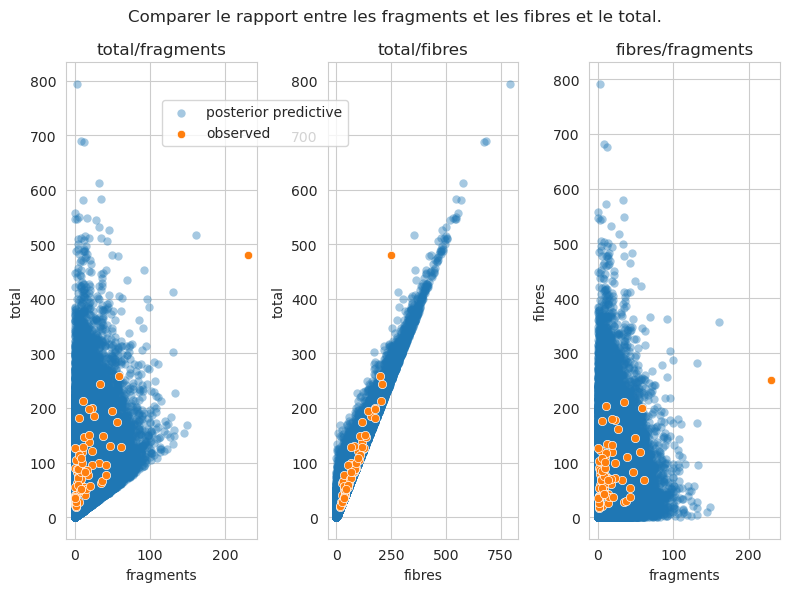

In [18]:
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(8,6))

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

sns.scatterplot(x=np.ravel(bi), y=pp_found_ravel, label="posterior predictive", linewidth=0, alpha=0.4,ax=ax2)
sns.scatterplot(x=np.ravel(ai), y=pp_found_ravel, alpha=0.4, linewidth=0, ax=ax1)
sns.scatterplot(x=np.ravel(ai), y=np.ravel(bi),  linewidth=0, alpha=0.4, ax=ax3)

sns.scatterplot(data=cData, x="fibres", y="total", label="observed", ax=ax2)
sns.scatterplot(data=cData, x="fragments", y="total", ax=ax1)
sns.scatterplot(data=cData, x="fragments", y="fibres", ax=ax3)

ax1.set_title("total/fragments")
ax2.set_title("total/fibres")
ax3.set_title("fibres/fragments")

h, l = ax2.get_legend_handles_labels()
ax2.get_legend().remove()

plt.suptitle("Comparer le rapport entre les fragments et les fibres et le total.")
fig.legend(h, l, bbox_to_anchor=(.2, .84), loc="upper left")
plt.tight_layout()

plt.show()

### Les résultats observés et prévus

Les résultats de VS et HS se situent dans le 90ème percentile de GE. Cela suggère que les échantillons de ces régions se situent dans la distribution prédite de GE ainsi que dans la distribution combinée pour le lac.

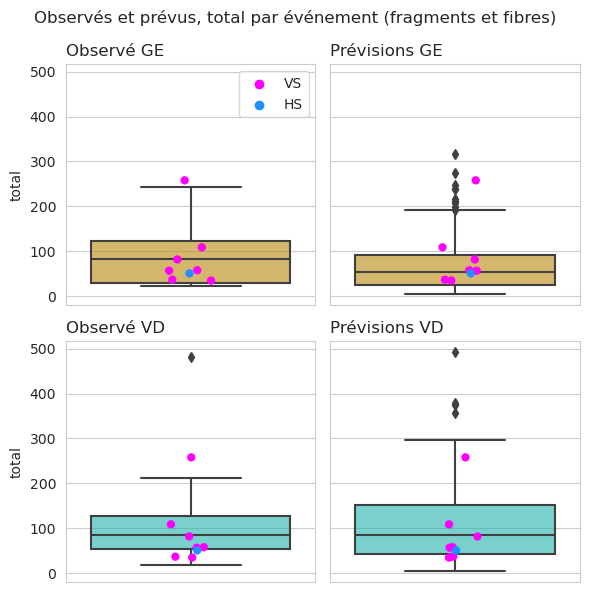

In [19]:
# get random samples from the posterior predictive:
pSampsg = rng.choice(pp_found_ravel, 128) # geneva
pSampsvd = rng.choice(pp_found_ravelvd, 128) # vaud

# get the observed values
priorvd = cData[cData.region == "VD"]["total"].values
priorg = cData[cData.region == "GE"]["total"].values

# get the samples not in VD or GE:
vs_hs = cData[cData.region.isin(["VS", "74"])].copy()
vs_hs = vs_hs[["city", "region", "E", "fibres", "fragments", "total"]]

# boxplots need to have the rgba:
rgba_ge = mpl.colors.to_rgba("darkgoldenrod")
rgba_ge = (rgba_ge[0], rgba_ge[1], rgba_ge[2], 0.6)

rgba_vd = mpl.colors.to_rgba("lightseagreen")
rgba_vd = (rgba_vd[0], rgba_vd[1], rgba_vd[2], 0.6)

# assign colors to VS and HS
color_vs = {"VS":"magenta", "74":"dodgerblue"}

fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(6,6))

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

sns.boxplot(priorg, ax=ax1, showfliers=True, boxprops={"facecolor":rgba_ge})
sns.boxplot(pSampsg, ax=ax2, showfliers=True, boxprops={"facecolor":rgba_ge})
sns.stripplot(data=vs_hs, y="total", hue="region", s=6, palette=color_vs, ax=ax1)
sns.stripplot(data=vs_hs, y="total", hue="region",  s=6, palette=color_vs, ax=ax2)

sns.boxplot(priorvd, ax=ax3, showfliers=True, boxprops={"facecolor":rgba_vd})
sns.boxplot(pSampsvd, ax=ax4, showfliers=True, boxprops={"facecolor":rgba_vd})
sns.stripplot(data=vs_hs, y="total", hue="region",  s=6, palette=color_vs, ax=ax3)
sns.stripplot(data=vs_hs, y="total", hue="region",  s=6, palette=color_vs, ax=ax4)

ax1.set_title("Observé GE", loc="left")
ax2.set_title("Prévisions GE", loc="left")
ax3.set_title("Observé VD", loc="left")
ax4.set_title("Prévisions VD", loc="left")

h, l = ax1.get_legend_handles_labels()
l = ["VS", "HS"]

ax1.legend(h, l)

for anax in [ax2, ax3, ax4]:
    anax.get_legend().remove()

ax4.set_xticklabels([])
plt.suptitle("Observés et prévus, total par événement (fragments et fibres)", y=.98) 
plt.tight_layout()

plt.show()

(section-six)=
### Pièces par mètre carré

Chaque élément représente 100cm² de plage. Par conséquent, 100 échantillons sont égaux à 1m², la somme de ces échantillons est la quantité attendue par m².  La distribution prédictive postérieure a été échantillonnée 1 000 fois, à chaque fois la somme des 100 échantillons prédits a été calculée. 

L'intervalle de densité maximale (IDM) de 94% (tous matériaux confondus) pour VD est de 9'112 - 12'174 pièces par m², pour GE de 6'447 - 8'707 pièces par m². Pris ensemble (VD + GE) la valeur attendue (94% HDI) par m² est de 6'505 11'836.

Ceci est significativement plus élevé que Faure 2014 et que les échantillons récents au Tessin.

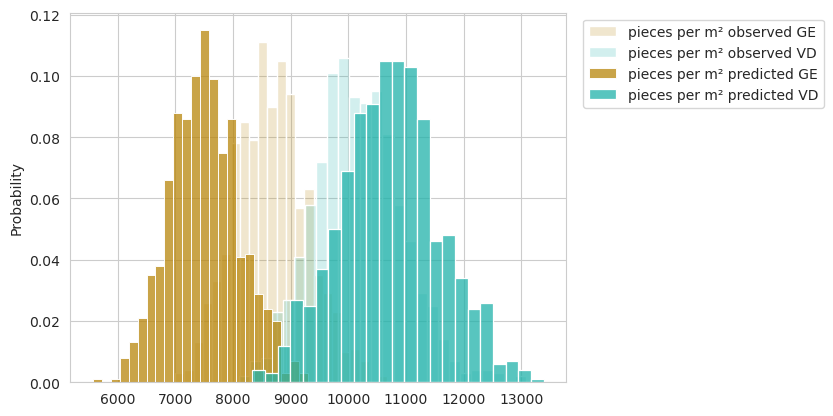

In [20]:
# draw 100 samples 1000 times from each of the posterior preidcitive distributions
some_samsVD= [np.sum(rng.choice(pp_found_ravelvd, 100)) for x in np.arange(1001)]
some_samsGE= [np.sum(rng.choice(pp_found_ravel, 100)) for x in np.arange(1001)]

# get the HDO for each
HDI_VD = az.hdi(np.array(some_samsVD))
HDI_GE = az.hdi(np.array(some_samsGE))
HDI_LAKE = az.hdi(np.array([*some_samsVD, *some_samsGE]))

# draw 100 samples 1000 times from each of the observed distributions
oVD = [np.sum(rng.choice(cData[cData.region.isin(["VD"])].total.values, 100)) for x in np.arange(1000)]
gVD = [np.sum(rng.choice(cData[cData.region.isin(["GE"])].total.values, 100)) for x in np.arange(1000)]

fig, ax = plt.subplots()

sns.histplot(gVD, label="pieces per m² observed GE", stat="probability", color=region_palette["GE"], alpha=0.2, ax=ax)
sns.histplot(oVD,label="pieces per m² observed VD", stat="probability",  color=region_palette["VD"], alpha=0.2, ax=ax)
sns.histplot(some_samsGE, label="pieces per m² predicted GE", stat="probability", color=region_palette["GE"])
sns.histplot(some_samsVD, label="pieces per m² predicted VD", stat="probability", color=region_palette["VD"])

l, h = ax.get_legend_handles_labels()

plt.legend(l,h, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()